In [1]:
import numpy as np
from numpy import random
import pandas as pd
import math
from math import sqrt

from matplotlib import pyplot as plt
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

In [2]:
# read in flows data
london_flows = pd.read_csv('london_flows.csv')
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [3]:
#create a pivot table to change paired list to a matrix and also compute the margin
london_flows_matrix = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
london_flows_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


### **III.1 Models and calibration**

In [4]:
# take log of the equation
# remove all values = 0
cdata_flows = london_flows[["flows", "distance"]]
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["distance"])
y = np.log(cdata_flows["flows"])

In [5]:

#delete NA value before taking logarithms
london_flows = london_flows[london_flows['population']!=0]
london_flows = london_flows[london_flows['jobs']!=0]
london_flows = london_flows[london_flows['distance']!=0]

#take log of variables
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    london_flows[f"log_{x}"] = np.log(london_flows[x])
    log_x_vars.append(f"log_{x}")

**Origin constrained--Inverse power**

In [6]:
#create the formula 
formula = 'flows ~ station_origin + log_jobs + log_distance-1' # -1 indicates no intercept in the regression model
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=london_flows, family=sm.families.Poisson()).fit()

In [7]:
predictions = prodSim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
london_flows["prodSimFitted"] = round(predictions_summary_frame["mean"],0)

In [8]:
# define r squared
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2


In [9]:
# define rmse
def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [10]:
CalcRSqaured(london_flows["flows"], london_flows["prodSimFitted"])

0.38827639501786243

In [11]:
CalcRMSE(london_flows["flows"], london_flows["prodSimFitted"])

102.893

**Origin constrained--negative exponential**

In [12]:
# creat Origin constrained model negative exponential
prosim_exp_form = "flows ~ station_origin + log_jobs + distance-1"
prodsim_exp = smf.glm(formula=prosim_exp_form, data = london_flows, family = sm.families.Poisson()).fit()

print(prodsim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Fri, 09 Sep 2022   Deviance:                   1.6477e+06
Time:                        16:33:24   Pearson chi2:                 2.40e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [13]:
#get the predictions
predictions_exp = prodsim_exp.get_prediction()
predictions_exp_summary_frame = predictions_exp.summary_frame()
london_flows["prosimest_exp"] = round(predictions_exp_summary_frame["mean"],0)

In [14]:
CalcRSqaured(london_flows["flows"],london_flows["prosimest_exp"])

0.4680648443542878

In [15]:
CalcRMSE(london_flows["flows"],london_flows["prosimest_exp"])

96.263

In [16]:
#create Oi and Dj columns in the dataframe and store row and column totals in them:
O_i = pd.DataFrame(london_flows.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flows = london_flows.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flows.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flows = london_flows.merge(D_j, on = "station_destination", how = "left" )

In [17]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

london_flows = london_flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
london_flows.drop(columns = ["coef"], inplace = True)

london_flows.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,prodSimFitted,prosimest_exp,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,78.0,599,78549,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1.0,1.0,599,442,3.250242


In [18]:
# parameters
alpha_i = prodsim_exp.params[0:-2]
print(alpha_i)

station_origin[Abbey Road]         -2.914322
station_origin[Acton Central]      -1.162092
station_origin[Acton Town]         -1.613081
station_origin[Aldgate]            -2.943047
station_origin[Aldgate East]       -2.854752
                                      ...   
station_origin[Wood Street]        -0.942621
station_origin[Woodford]           -0.633605
station_origin[Woodgrange Park]    -0.896422
station_origin[Woodside Park]      -1.149110
station_origin[Woolwich Arsenal]    0.518041
Length: 398, dtype: float64


In [19]:
beta = -prodsim_exp.params[-1]

In [20]:
print(beta)

0.0001531661934636844


## **IV.1. Scenario A**

In [21]:
# jobs decrease 50% in Canary Wharf
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val
        
london_flows["jobs_A"] = london_flows.apply(new_sal, axis =1)
london_flows.head(2)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,prodSimFitted,prosimest_exp,O_i,D_j,alpha_i,jobs_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0,78.0,599,78549,3.250242,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1.0,1.0,599,442,3.250242,442.0


In [22]:
gamma = prodsim_exp.params[-2]
london_flows["prodsimest1"] = np.exp(london_flows["alpha_i"]+gamma*np.log(london_flows["jobs_A"]) - beta*london_flows["distance"])

london_flows["prodsimest1"] = round(london_flows["prodsimest1"],0)
#now we can convert the pivot table into a matrix
london_flows_mat2 = london_flows.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
london_flows_mat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3556.0,265599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,159.0,NaN,NaN,590588.0
Acton Town,NaN,NaN,NaN,6211.0,6072.0,NaN,6579.0,20.0,NaN,7672.0,...,6415.0,1394.0,923.0,9433.0,NaN,109.0,NaN,259.0,NaN,1794670.0
Aldgate,NaN,NaN,693.0,NaN,19626.0,NaN,NaN,2.0,NaN,14473.0,...,1105.0,NaN,1315.0,1078.0,NaN,350.0,NaN,287.0,NaN,1503789.0
Aldgate East,NaN,NaN,764.0,22117.0,NaN,NaN,157.0,2.0,NaN,15940.0,...,1217.0,264.0,1448.0,1188.0,NaN,499.0,NaN,317.0,NaN,1725377.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,466.0,13464.0,17021.0,NaN,NaN,NaN,NaN,9922.0,...,743.0,NaN,1876.0,NaN,NaN,NaN,NaN,NaN,NaN,1565235.0
Woodgrange Park,NaN,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248690.0
Woodside Park,NaN,NaN,673.0,6687.0,6535.0,NaN,138.0,NaN,NaN,10919.0,...,1073.0,NaN,1313.0,NaN,NaN,NaN,NaN,NaN,NaN,1065752.0


In [23]:
Dj_gamma = london_flows["jobs_A"]**gamma #cal new values
dist_beta = london_flows["distance"]**-beta
london_flows["Ai1"] = Dj_gamma * dist_beta
A_i = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#write the A_i values back into the dataframe
london_flows = london_flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [24]:
london_flows["prodsimest2"] = london_flows["A_i"]*london_flows["O_i"]*Dj_gamma*dist_beta
#round london_flows prodsimest2
london_flows["prodsimest2"] = round(london_flows["prodsimest2"])

In [25]:
london_flows_mat4 = london_flows.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
london_flows_mat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,4.0,2.0,NaN,25.0,...,21.0,3.0,9.0,7.0,NaN,4.0,NaN,4.0,NaN,3745.0
Aldgate,NaN,NaN,7.0,NaN,19.0,NaN,NaN,1.0,NaN,19.0,...,16.0,NaN,7.0,5.0,NaN,3.0,NaN,3.0,NaN,2891.0
Aldgate East,NaN,NaN,8.0,20.0,NaN,NaN,3.0,2.0,NaN,20.0,...,17.0,3.0,7.0,6.0,NaN,3.0,NaN,3.0,NaN,3179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,32.0,32.0,NaN,NaN,NaN,NaN,33.0,...,27.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,4870.0
Woodgrange Park,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,8.0,21.0,21.0,NaN,4.0,NaN,NaN,22.0,...,18.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


In [26]:
#show the change
diff_1 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum'})
diff_1["differences_1"]= diff_1["prodsimest2"] - diff_1["flows"]

diff_1["diff_abs"]= abs(diff_1["differences_1"])
diff_1.sort_values(by=["diff_abs"],ascending= False, inplace = True)
diff_1.head(10)

,station_destination,flows,prodsimest2,differences_1,diff_abs
54,Canary Wharf,58772,30481.0,-28291.0,28291.0
326,Stratford,55954,74119.0,18165.0,18165.0
15,Bank and Monument,78549,62870.0,-15679.0,15679.0
251,Oxford Circus,44368,31325.0,-13043.0,13043.0
355,Victoria,33251,24541.0,-8710.0,8710.0
197,King's Cross St. Pancras,33330,24717.0,-8613.0,8613.0
213,London Bridge,29926,22750.0,-7176.0,7176.0
138,Green Park,26754,21351.0,-5403.0,5403.0
364,Waterloo,23408,18403.0,-5005.0,5005.0
119,Farringdon,25592,20614.0,-4978.0,4978.0


In [27]:
diff1 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum'})
diff1["differences1"]= diff1["prodsimest2"] - diff1["flows"]

diff1["diff_abs"]= abs(diff1["differences1"])
diff1.sort_values(by=["differences1"],ascending= False, inplace = True)
diff1 = diff1.head(10)
diff1

,station_destination,flows,prodsimest2,differences1,diff_abs
326,Stratford,55954,74119.0,18165.0,18165.0
386,Whitechapel,17633,21640.0,4007.0,4007.0
167,Highbury & Islington,25385,28929.0,3544.0,3544.0
53,Canada Water,20443,23714.0,3271.0,3271.0
55,Canning Town,15428,18687.0,3259.0,3259.0
371,West Brompton,5859,9113.0,3254.0,3254.0
388,Willesden Junction,4165,7181.0,3016.0,3016.0
293,Shepherd's Bush,9890,12830.0,2940.0,2940.0
141,Gunnersbury,4775,7644.0,2869.0,2869.0
374,West Ham,5487,8288.0,2801.0,2801.0


In [28]:
diff_d = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum'})
diff_d["differences_d"]= diff_d["prodsimest2"] - diff_d["flows"]

diff_d["diff_abs_d"]= abs(diff_d["differences_d"])
diff_d.sort_values(by=["differences_d"],ascending= True, inplace = True)
diff_d = diff_d.head(11)
diff_d

,station_destination,flows,prodsimest2,differences_d,diff_abs_d
54,Canary Wharf,58772,30481.0,-28291.0,28291.0
15,Bank and Monument,78549,62870.0,-15679.0,15679.0
251,Oxford Circus,44368,31325.0,-13043.0,13043.0
355,Victoria,33251,24541.0,-8710.0,8710.0
197,King's Cross St. Pancras,33330,24717.0,-8613.0,8613.0
213,London Bridge,29926,22750.0,-7176.0,7176.0
138,Green Park,26754,21351.0,-5403.0,5403.0
364,Waterloo,23408,18403.0,-5005.0,5005.0
119,Farringdon,25592,20614.0,-4978.0,4978.0
227,Moorgate,24574,19923.0,-4651.0,4651.0


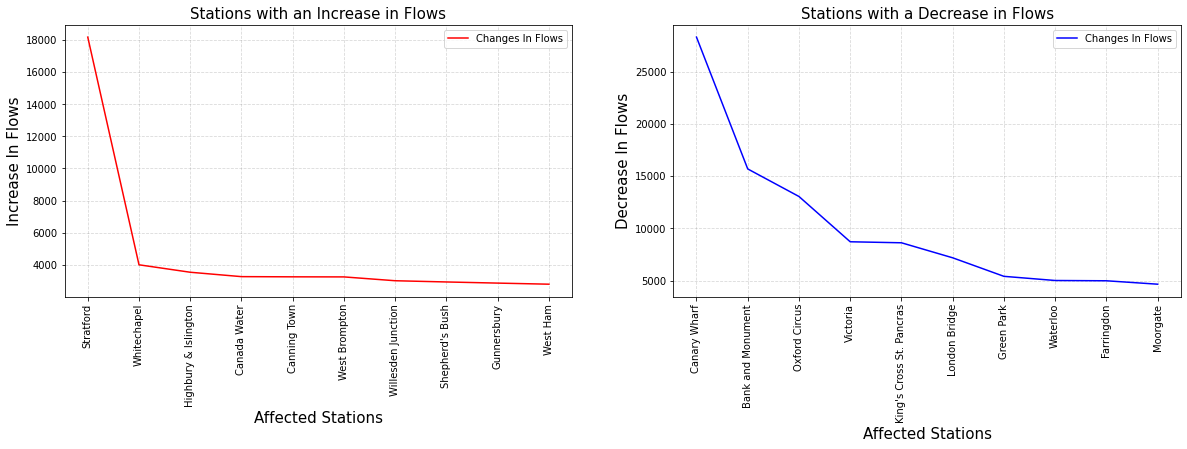

In [30]:
#plot Changes In Flows under scenario A
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].set_title('Stations with an Increase in Flows', fontsize=15)
ax[0].plot(list(diff1['diff_abs'][:10]), color = "red", label = 'Changes In Flows') 
ax[0].grid(color='grey', linestyle='--',alpha=0.3) 
ax[0].set_xlabel("Affected Stations", fontsize=15) 
ax[0].set_ylabel("Increase In Flows", fontsize=15)  
ax[0].set_xticks(list(range(10))) 
ax[0].set_xticklabels(list(diff1['station_destination'])[:10], rotation=90)
ax[0].legend(loc=1)

ax[1].set_title('Stations with a Decrease in Flows', fontsize=15)
ax[1].plot(list(diff_d['diff_abs_d'][:10]), color = "blue", label = 'Changes In Flows') 
ax[1].grid(color='grey', linestyle='--',alpha=0.3) 
ax[1].set_xlabel("Affected Stations", fontsize=15) 
ax[1].set_ylabel("Decrease In Flows", fontsize=15)  
ax[1].set_xticks(list(range(10))) 
ax[1].set_xticklabels(list(diff_d['station_destination'])[:10], rotation=90)
ax[1].legend(loc=1)
plt.show()

## **IV.2. Scenario B1**

In [31]:
# set the new beta
beta_1 = 1

In [32]:
Dj_gamma1 = london_flows["jobs"]**gamma
dist_beta1 = london_flows["distance"]**-beta_1
#calcualte the first stage of the Ai values
london_flows["Ai1_new1"] = Dj_gamma1 * dist_beta1
A_i_new1 = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1_new1"].agg(np.sum))
#divide into 1
A_i_new1["Ai1_new1"] = 1/A_i_new1["Ai1_new1"]
A_i_new1.rename(columns={"Ai1_new1":"A_i_new1"}, inplace=True)
#write the A_i values back into the dataframe
london_flows = london_flows.merge(A_i_new1, left_on="station_origin", right_index=True, how="left")

In [33]:
#create the original estimates
london_flows["prodsimest3"] = london_flows["A_i_new1"]*london_flows["O_i"]*Dj_gamma1*dist_beta1
london_flows["prodsimest3"] = round(london_flows["prodsimest3"])

In [34]:
diff_2 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest3':'sum'})
diff_2["differences_2"]= diff_2["prodsimest3"] - diff_2["flows"]
diff_2["diff_abs1"]= abs(diff_2["differences_2"])
diff_2.sort_values(by=["diff_abs1"],ascending= False, inplace = True)
diff_2.head(10)

,station_destination,flows,prodsimest3,differences_2,diff_abs1
54,Canary Wharf,58772,49095.0,-9677.0,9677.0
15,Bank and Monument,78549,70850.0,-7699.0,7699.0
326,Stratford,55954,63319.0,7365.0,7365.0
251,Oxford Circus,44368,37082.0,-7286.0,7286.0
355,Victoria,33251,26853.0,-6398.0,6398.0
147,Hammersmith,18250,13123.0,-5127.0,5127.0
53,Canada Water,20443,25342.0,4899.0,4899.0
386,Whitechapel,17633,22531.0,4898.0,4898.0
197,King's Cross St. Pancras,33330,28619.0,-4711.0,4711.0
252,Paddington,20193,16129.0,-4064.0,4064.0


In [35]:
diff2 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest3':'sum'})
diff2["differences2"]= diff2["prodsimest3"] - diff2["flows"]

diff2["diff_abs1"]= abs(diff2["differences2"])
diff2.sort_values(by=["differences2"],ascending= False, inplace = True)
diff2 = diff2.head(10)
diff2

,station_destination,flows,prodsimest3,differences2,diff_abs1
326,Stratford,55954,63319.0,7365.0,7365.0
53,Canada Water,20443,25342.0,4899.0,4899.0
386,Whitechapel,17633,22531.0,4898.0,4898.0
112,Embankment,10220,14162.0,3942.0,3942.0
313,Southwark,10326,14093.0,3767.0,3767.0
383,Westminster,15466,18544.0,3078.0,3078.0
56,Cannon Street,4698,7597.0,2899.0,2899.0
64,Charing Cross,7016,9825.0,2809.0,2809.0
167,Highbury & Islington,25385,28131.0,2746.0,2746.0
374,West Ham,5487,8131.0,2644.0,2644.0


In [36]:
diff_d1 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest3':'sum'})
diff_d1["differences_d1"]= diff_d1["prodsimest3"] - diff_d1["flows"]

diff_d1["diff_abs_d1"]= abs(diff_d1["differences_d1"])
diff_d1.sort_values(by=["differences_d1"],ascending= True, inplace = True)
diff_d1 = diff_d1.head(10)
diff_d1

,station_destination,flows,prodsimest3,differences_d1,diff_abs_d1
54,Canary Wharf,58772,49095.0,-9677.0,9677.0
15,Bank and Monument,78549,70850.0,-7699.0,7699.0
251,Oxford Circus,44368,37082.0,-7286.0,7286.0
355,Victoria,33251,26853.0,-6398.0,6398.0
147,Hammersmith,18250,13123.0,-5127.0,5127.0
197,King's Cross St. Pancras,33330,28619.0,-4711.0,4711.0
252,Paddington,20193,16129.0,-4064.0,4064.0
397,Woolwich Arsenal,4428,954.0,-3474.0,3474.0
389,Wimbledon,6295,3152.0,-3143.0,3143.0
73,Clapham Junction,4969,1852.0,-3117.0,3117.0


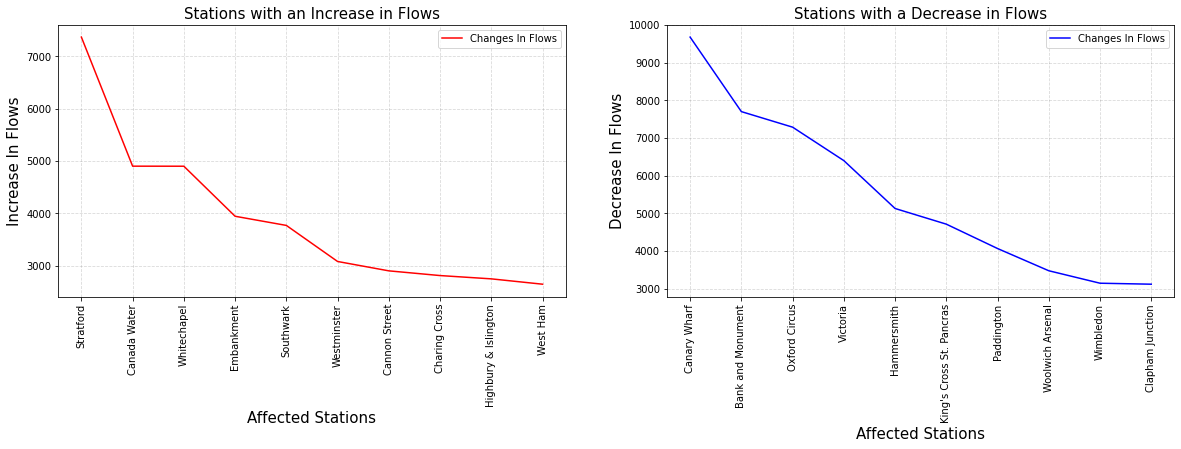

In [37]:
#plot change in flow of scenario B1
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].set_title('Stations with an Increase in Flows', fontsize=15)
ax[0].plot(list(diff2['diff_abs1'][:10]), color = "red", label = 'Changes In Flows') 
ax[0].grid(color='grey', linestyle='--',alpha=0.3) 
ax[0].set_xlabel("Affected Stations", fontsize=15) 
ax[0].set_ylabel("Increase In Flows", fontsize=15)  
ax[0].set_xticks(list(range(10))) 
ax[0].set_xticklabels(list(diff2['station_destination'])[:10], rotation=90)
ax[0].legend(loc=1)


ax[1].set_title('Stations with a Decrease in Flows', fontsize=15)
ax[1].plot(list(diff_d1['diff_abs_d1'][:10]), color = "blue", label = 'Changes In Flows') 
ax[1].grid(color='grey', linestyle='--',alpha=0.3) 
ax[1].set_xlabel("Affected Stations", fontsize=15) 
ax[1].set_ylabel("Decrease In Flows", fontsize=15)  
ax[1].set_xticks(list(range(10))) 
ax[1].set_xticklabels(list(diff_d1['station_destination'])[:10], rotation=90)
ax[1].legend(loc=1)
plt.show()

### **IV.2. Scenario B2**

In [38]:
# set the new beta
beta_2 = 2

In [39]:
Dj_gamma2 = london_flows["jobs"]**gamma
dist_beta2 = london_flows["distance"]**-beta_2

london_flows["Ai1_new2"] = Dj_gamma2 * dist_beta2
A_i_new2 = pd.DataFrame(london_flows.groupby(["station_origin"])["Ai1_new2"].agg(np.sum))
A_i_new2["Ai1_new2"] = 1/A_i_new2["Ai1_new2"]
A_i_new2.rename(columns={"Ai1_new2":"A_i_new2"}, inplace=True)

london_flows = london_flows.merge(A_i_new2, left_on="station_origin", right_index=True, how="left")

In [40]:
#recreate the original estimates
london_flows["prodsimest4"] = london_flows["A_i_new2"]*london_flows["O_i"]*Dj_gamma2*dist_beta2
london_flows["prodsimest4"] = round(london_flows["prodsimest4"])

In [41]:
diff_3 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest4':'sum'})
diff_3["differences_3"]= diff_3["prodsimest4"] - diff_3["flows"]
diff_3["diff_abs2"]= abs(diff_3["differences_3"])
diff_3.sort_values(by=["diff_abs2"],ascending= False, inplace = True)
diff_3.head(10)

,station_destination,flows,prodsimest4,differences_3,diff_abs2
54,Canary Wharf,58772,40985.0,-17787.0,17787.0
251,Oxford Circus,44368,30320.0,-14048.0,14048.0
212,Liverpool Street,61122,47469.0,-13653.0,13653.0
15,Bank and Monument,78549,65885.0,-12664.0,12664.0
355,Victoria,33251,21639.0,-11612.0,11612.0
327,Stratford High Street,788,10118.0,9330.0,9330.0
119,Farringdon,25592,16362.0,-9230.0,9230.0
313,Southwark,10326,18012.0,7686.0,7686.0
197,King's Cross St. Pancras,33330,25881.0,-7449.0,7449.0
227,Moorgate,24574,31947.0,7373.0,7373.0


In [42]:
diff3 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest4':'sum'})
diff3["differences3"]= diff3["prodsimest4"] - diff3["flows"]

diff3["diff_abs2"]= abs(diff3["differences3"])
diff3.sort_values(by=["differences3"],ascending= False, inplace = True)
diff3 = diff3.head(10)
diff3

,station_destination,flows,prodsimest4,differences3,diff_abs2
327,Stratford High Street,788,10118.0,9330.0,9330.0
313,Southwark,10326,18012.0,7686.0,7686.0
227,Moorgate,24574,31947.0,7373.0,7373.0
112,Embankment,10220,17055.0,6835.0,6835.0
374,West Ham,5487,11385.0,5898.0,5898.0
56,Cannon Street,4698,10379.0,5681.0,5681.0
383,Westminster,15466,20610.0,5144.0,5144.0
163,Heron Quays,5975,10535.0,4560.0,4560.0
315,St. James's Park,13339,17533.0,4194.0,4194.0
107,Edgware Road,6868,10967.0,4099.0,4099.0


In [43]:
diff_d2 = london_flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest4':'sum'})
diff_d2["differences_d2"]= diff_d2["prodsimest4"] - diff_d2["flows"]

diff_d2["diff_abs_d2"]= abs(diff_d2["differences_d2"])
diff_d2.sort_values(by=["differences_d2"],ascending= True, inplace = True)
diff_d2 = diff_d2.head(10)
diff_d2

,station_destination,flows,prodsimest4,differences_d2,diff_abs_d2
54,Canary Wharf,58772,40985.0,-17787.0,17787.0
251,Oxford Circus,44368,30320.0,-14048.0,14048.0
212,Liverpool Street,61122,47469.0,-13653.0,13653.0
15,Bank and Monument,78549,65885.0,-12664.0,12664.0
355,Victoria,33251,21639.0,-11612.0,11612.0
119,Farringdon,25592,16362.0,-9230.0,9230.0
197,King's Cross St. Pancras,33330,25881.0,-7449.0,7449.0
252,Paddington,20193,13391.0,-6802.0,6802.0
326,Stratford,55954,49764.0,-6190.0,6190.0
147,Hammersmith,18250,12116.0,-6134.0,6134.0


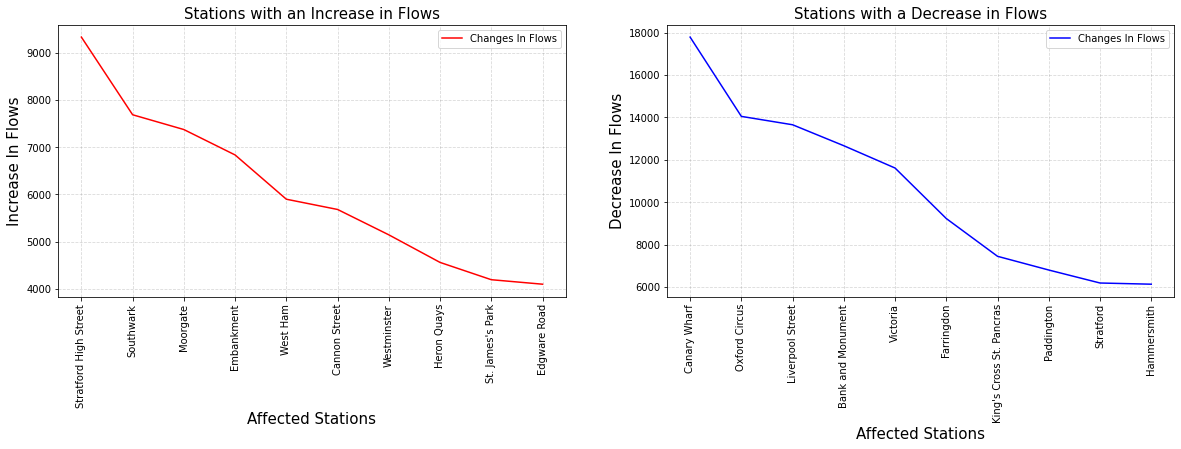

In [44]:
#plot change in flow of scenario B2
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].set_title('Stations with an Increase in Flows', fontsize=15)
ax[0].plot(list(diff3['diff_abs2'][:10]), color = "red", label = 'Changes In Flows') 
ax[0].grid(color='grey', linestyle='--',alpha=0.3) 
ax[0].set_xlabel("Affected Stations", fontsize=15) 
ax[0].set_ylabel("Increase In Flows", fontsize=15)  
ax[0].set_xticks(list(range(10))) 
ax[0].set_xticklabels(list(diff3['station_destination'])[:10], rotation=90)
ax[0].legend(loc=1)


ax[1].set_title('Stations with a Decrease in Flows', fontsize=15) 
ax[1].plot(list(diff_d2['diff_abs_d2'][:10]), color = "blue", label = 'Changes In Flows') 
ax[1].grid(color='grey', linestyle='--',alpha=0.3) 
ax[1].set_xlabel("Affected Stations", fontsize=15) 
ax[1].set_ylabel("Decrease In Flows", fontsize=15)  
ax[1].set_xticks(list(range(10))) 
ax[1].set_xticklabels(list(diff_d2['station_destination'])[:10], rotation=90)
ax[1].legend(loc=1)
plt.show()

### **Compare 3 situations**

In [45]:
comb_AB = diff_1[['station_destination','flows','prodsimest2']]
comb_AB = pd.merge(comb_AB,diff_2[['prodsimest3','station_destination']],on='station_destination')
comb_AB = pd.merge(comb_AB,diff_3[['prodsimest4','station_destination']],on='station_destination')

comb_AB

,station_destination,flows,prodsimest2,prodsimest3,prodsimest4
0,Canary Wharf,58772,30481.0,49095.0,40985.0
1,Stratford,55954,74119.0,63319.0,49764.0
2,Bank and Monument,78549,62870.0,70850.0,65885.0
3,Oxford Circus,44368,31325.0,37082.0,30320.0
4,Victoria,33251,24541.0,26853.0,21639.0
...,...,...,...,...,...
393,Kensal Rise,1376,1361.0,1059.0,1006.0
394,Maryland,350,335.0,664.0,1901.0
395,Canonbury,846,833.0,1078.0,1838.0
396,Kentish Town West,1128,1135.0,1030.0,962.0


In [46]:
#calculate the percentage of changes under A B scenarios
comb_AB['ChangeA']=((comb_AB['prodsimest2']-comb_AB['flows'])/comb_AB['flows'])*100
comb_AB['ChangeB1']=((comb_AB['prodsimest3']-comb_AB['flows'])/comb_AB['flows'])*100
comb_AB['ChangeB2']=((comb_AB['prodsimest4']-comb_AB['flows'])/comb_AB['flows'])*100
comb_AB

,station_destination,flows,prodsimest2,prodsimest3,prodsimest4,ChangeA,ChangeB1,ChangeB2
0,Canary Wharf,58772,30481.0,49095.0,40985.0,-48.136868,-16.465324,-30.264412
1,Stratford,55954,74119.0,63319.0,49764.0,32.464167,13.162598,-11.062659
2,Bank and Monument,78549,62870.0,70850.0,65885.0,-19.960789,-9.801525,-16.122420
3,Oxford Circus,44368,31325.0,37082.0,30320.0,-29.397313,-16.421745,-31.662459
4,Victoria,33251,24541.0,26853.0,21639.0,-26.194701,-19.241527,-34.922258
...,...,...,...,...,...,...,...,...
393,Kensal Rise,1376,1361.0,1059.0,1006.0,-1.090116,-23.037791,-26.889535
394,Maryland,350,335.0,664.0,1901.0,-4.285714,89.714286,443.142857
395,Canonbury,846,833.0,1078.0,1838.0,-1.536643,27.423168,117.257683
396,Kentish Town West,1128,1135.0,1030.0,962.0,0.620567,-8.687943,-14.716312


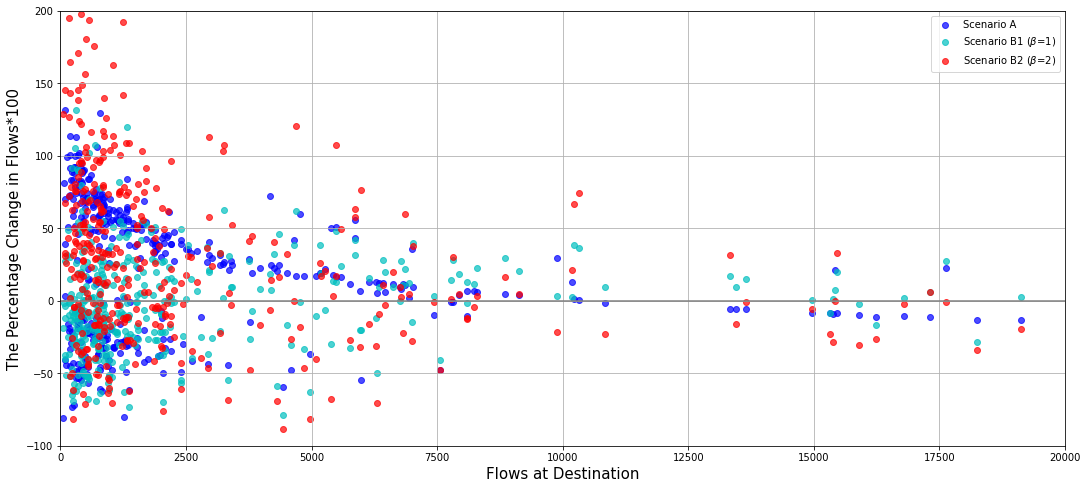

In [47]:
fig, ax = plt.subplots(figsize=(18,8))

alpha=0.5
plt.xlim(0,20000)
plt.ylim(-100,200)

plt.scatter(comb_AB['flows'],comb_AB['ChangeA'],alpha=0.7,label='Scenario A ', c='b')
plt.scatter(comb_AB['flows'],comb_AB['ChangeB1'],alpha=0.7,label=r'Scenario B1 ($\beta$=1)', c='c')
plt.scatter(comb_AB['flows'],comb_AB['ChangeB2'],alpha=0.7,label=r'Scenario B2 ($\beta$=2)', c='r')

plt.axhline(color="grey", linestyle="-")
ax.legend()
plt.legend(loc='upper right')
ax.grid(True)
ax.set_xlabel('Flows at Destination', fontsize=15)
ax.set_ylabel('The Percentage Change in Flows*100', fontsize=15)

plt.show()